<a href="https://colab.research.google.com/github/DigitalGoldRush/Project-2-Emotional-recognition/blob/main/emotion_recognition_v5(working%20copy).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from tensorflow import keras
from keras import layers
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
RANDOM_SEED = 123


In [4]:
#Faster way to upload zip files from gdrive to colab
# ID of Kaggle emotional dataset
! gdown --id 1wrwLq6DqNHLDxU18RYUPY0WcV4ZNG70P

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1wrwLq6DqNHLDxU18RYUPY0WcV4ZNG70P
To: /content/emotional dataset.zip
100% 62.6M/62.6M [00:00<00:00, 280MB/s]


In [5]:
# Required to save models in HDF5 format
!pip install pyyaml h5py 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# zip file opener
!pip install patool
import patoolib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 4.5 MB/s 


In [7]:
patoolib.extract_archive('/content/emotional dataset.zip')

patool: Extracting /content/emotional dataset.zip ...
patool: running /usr/bin/7z x -o./Unpack_2agwc1bw -- "/content/emotional dataset.zip"
patool: ... /content/emotional dataset.zip extracted to `emotional dataset' (multiple files in root).


'emotional dataset'

In [8]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [9]:
# data preparation
train_dir = '/content/emotional dataset/Training/Training'
test_dir = '/content/emotional dataset/Testing/Testing'

train_angry_dir = '/content/emotional dataset/Training/Training/Angry'
train_fear_dir = '/content/emotional dataset/Training/Training/Fear'
train_happy_dir = '/content/emotional dataset/Training/Training/Happy'
train_neutral_dir = '/content/emotional dataset/Training/Training/Neutral'
train_sad_dir = '/content/emotional dataset/Training/Training/Sad'
train_surprise_dir = '/content/emotional dataset/Training/Training/Suprise'

test_angry_dir = '/content/emotional dataset/Testing/Testing/Angry'
test_fear_dir = '/content/emotional dataset/Testing/Testing/Fear'
test_happy_dir = '/content/emotional dataset/Testing/Testing/Happy'
test_neural_dir = '/content/emotional dataset/Testing/Testing/Neutral'
test_sad_dir = '/content/emotional dataset/Testing/Testing/Sad'
test_surprise_dir = '/content/emotional dataset/Testing/Testing/Suprise'

dir_list = [train_angry_dir, train_fear_dir, train_happy_dir,
           train_neutral_dir, train_sad_dir, train_surprise_dir,
           test_angry_dir, test_fear_dir, test_happy_dir,
           test_neural_dir, test_sad_dir, test_surprise_dir]

for d in dir_list:
    print(d, len(os.listdir(d)))


/content/emotional dataset/Training/Training/Angry 3995
/content/emotional dataset/Training/Training/Fear 4097
/content/emotional dataset/Training/Training/Happy 7215
/content/emotional dataset/Training/Training/Neutral 4965
/content/emotional dataset/Training/Training/Sad 4830
/content/emotional dataset/Training/Training/Suprise 3171
/content/emotional dataset/Testing/Testing/Angry 958
/content/emotional dataset/Testing/Testing/Fear 1024
/content/emotional dataset/Testing/Testing/Happy 1774
/content/emotional dataset/Testing/Testing/Neutral 1233
/content/emotional dataset/Testing/Testing/Sad 1247
/content/emotional dataset/Testing/Testing/Suprise 831


In [10]:
# image generator

train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(150,150),
                                                   batch_size=64,
                                                   class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

validation_generator = validation_datagen.flow_from_directory(test_dir,
                                                             target_size=(150,150),
                                                             batch_size=62,
                                                             class_mode='categorical')

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [11]:
# callback function

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                 restore_best_weights=True)

In [12]:
# build the model = RMS Optimizer, Relu Activation

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(6, activation='softmax')  
])

from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()
# keras.utils.plot_model(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [13]:
# train the model

history = model.fit(train_generator,
                   epochs=10,
                   verbose=1,
                   validation_data=validation_generator,
                   callbacks=early_stopping_cb)


Epoch 1/10
442/442 [==============================] - 177s 365ms/step - loss: 1.7453 - accuracy: 0.2558 - val_loss: 1.6778 - val_accuracy: 0.3034
Epoch 2/10
442/442 [==============================] - 149s 336ms/step - loss: 1.6831 - accuracy: 0.2908 - val_loss: 1.5935 - val_accuracy: 0.3471
Epoch 3/10
442/442 [==============================] - 147s 332ms/step - loss: 1.6164 - accuracy: 0.3335 - val_loss: 1.4563 - val_accuracy: 0.4239
Epoch 4/10
442/442 [==============================] - 147s 334ms/step - loss: 1.5578 - accuracy: 0.3638 - val_loss: 1.4522 - val_accuracy: 0.4346
Epoch 5/10
442/442 [==============================] - 148s 336ms/step - loss: 1.4940 - accuracy: 0.3991 - val_loss: 1.3423 - val_accuracy: 0.4753
Epoch 6/10
442/442 [==============================] - 148s 334ms/step - loss: 1.4547 - accuracy: 0.4173 - val_loss: 1.3098 - val_accuracy: 0.4817
Epoch 7/10
442/442 [==============================] - 148s 334ms/step - loss: 1.4203 - accuracy: 0.4338 - val_loss: 1.3554 -

In [14]:
# save the model to g-drive because files are discarded on colab after a period of time
# change the name each time or it will be overwritten
# model.save('facial_reco_base_model.h5')

model.save("/content/drive/MyDrive/Colab Notebooks/Project 2_ Emotion Recognition/facial_reco_whole_model_V3")
# change the file name!!


In [15]:
# Evaluate the model loss and accuracy metrics using the evaluate_generator method and the test generator
test_loss, test_acc = model.evaluate(validation_generator, verbose=2)

# Display the model's loss and accuracy results
print(f"Loss: {test_loss}, Accuracy: {test_acc}")


114/114 - 5s - loss: 1.1960 - accuracy: 0.5304 - 5s/epoch - 40ms/step
Loss: 1.1959903240203857, Accuracy: 0.5303523540496826


model_adam = ADAM optimizer, Relu **Activation** **bold text**

In [16]:
# Build model_adam = ADAM optimizer, Relu Activation function

model_adam = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

from tensorflow.keras.optimizers import Adam

# Compile the model
model_adam.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_adam.summary()


    

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 64)      

In [17]:
# train the model_adam
history = model_adam.fit(train_generator,
                   epochs=10,
                   verbose=1,
                   validation_data=validation_generator,
                   callbacks=early_stopping_cb)

Epoch 1/10
442/442 [==============================] - 149s 335ms/step - loss: 1.7402 - accuracy: 0.2583 - val_loss: 1.7010 - val_accuracy: 0.2807
Epoch 2/10
442/442 [==============================] - 153s 346ms/step - loss: 1.7126 - accuracy: 0.2731 - val_loss: 1.6740 - val_accuracy: 0.2901
Epoch 3/10
442/442 [==============================] - 150s 339ms/step - loss: 1.6952 - accuracy: 0.2807 - val_loss: 1.6449 - val_accuracy: 0.3167
Epoch 4/10
442/442 [==============================] - 154s 349ms/step - loss: 1.6699 - accuracy: 0.3000 - val_loss: 1.5690 - val_accuracy: 0.3590
Epoch 5/10
442/442 [==============================] - 152s 343ms/step - loss: 1.6081 - accuracy: 0.3416 - val_loss: 1.4900 - val_accuracy: 0.3990
Epoch 6/10
442/442 [==============================] - 153s 347ms/step - loss: 1.5414 - accuracy: 0.3794 - val_loss: 1.4183 - val_accuracy: 0.4418
Epoch 7/10
442/442 [==============================] - 151s 341ms/step - loss: 1.4822 - accuracy: 0.4030 - val_loss: 1.3615 -

In [18]:
# Evaluate the model_adam loss and accuracy metrics using the evaluate_generator method and the test generator
test_loss, test_acc = model_adam.evaluate(validation_generator, verbose=2)

# Display the model's loss and accuracy results
print(f"Model_adam Loss: {test_loss}, Model_adam Accuracy: {test_acc}")


114/114 - 5s - loss: 1.2517 - accuracy: 0.5069 - 5s/epoch - 44ms/step
Model_adam Loss: 1.2517268657684326, Model_adam Accuracy: 0.5068628787994385


# model_swish = RMS Optimizer, Swish **Activation** 


In [27]:
# Build model_swish = RMS Optimizer, Swish Activation

model_swish = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='swish', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='swish'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='swish'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='swish'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='swish'),
    tf.keras.layers.Dense(6, activation='softmax')
])

# compile the model_swish
model_swish.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics = ['accuracy']) 
model_swish.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 17, 17, 64)      

In [21]:
# train the model_swish
history_swish = model_swish.fit(train_generator, epochs=10, verbose=1, validation_data=validation_generator, callbacks=early_stopping_cb)



Epoch 1/10
442/442 [==============================] - 151s 338ms/step - loss: 1.7440 - accuracy: 0.2558 - val_loss: 1.6929 - val_accuracy: 0.2846
Epoch 2/10
442/442 [==============================] - 148s 334ms/step - loss: 1.7029 - accuracy: 0.2840 - val_loss: 1.6013 - val_accuracy: 0.3519
Epoch 3/10
442/442 [==============================] - 149s 338ms/step - loss: 1.6624 - accuracy: 0.3147 - val_loss: 1.5361 - val_accuracy: 0.3971
Epoch 4/10
442/442 [==============================] - 149s 337ms/step - loss: 1.6318 - accuracy: 0.3330 - val_loss: 1.4972 - val_accuracy: 0.4138
Epoch 5/10
442/442 [==============================] - 148s 335ms/step - loss: 1.6064 - accuracy: 0.3468 - val_loss: 1.4813 - val_accuracy: 0.4030
Epoch 6/10
442/442 [==============================] - 147s 333ms/step - loss: 1.5783 - accuracy: 0.3592 - val_loss: 1.4710 - val_accuracy: 0.4053
Epoch 7/10
442/442 [==============================] - 147s 332ms/step - loss: 1.5565 - accuracy: 0.3705 - val_loss: 1.4026 -

In [22]:
# Evaluate the model_swish loss and accuracy metrics using the evaluate_generator method and the test generator
test_loss, test_acc = model_swish.evaluate(validation_generator, verbose=2)

# Display the model's loss and accuracy results
print(f"Model_swish Loss: {test_loss}, Model_swish Accuracy: {test_acc}")


114/114 - 5s - loss: 1.3205 - accuracy: 0.4811 - 5s/epoch - 43ms/step
Model_swish Loss: 1.3205163478851318, Model_swish Accuracy: 0.4811093807220459


In [23]:
# Build model_adam_swish = ADAM Optimizer, Swish Activation

model_adam_swish = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='swish', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='swish'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='swish'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='swish'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='swish'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_adam_swish.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
model_adam_swish.summary()
# keras.utils.plot_model(model_adam_swish)



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 17, 17, 64)      

In [24]:
# train the model_adam_swish
history_adam_swish = model_adam_swish.fit(train_generator, 
                    epochs=10,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=early_stopping_cb)



Epoch 1/10
442/442 [==============================] - 151s 340ms/step - loss: 1.7438 - accuracy: 0.2584 - val_loss: 1.7194 - val_accuracy: 0.2660
Epoch 2/10
442/442 [==============================] - 146s 331ms/step - loss: 1.7198 - accuracy: 0.2704 - val_loss: 1.6642 - val_accuracy: 0.3290
Epoch 3/10
442/442 [==============================] - 146s 331ms/step - loss: 1.6963 - accuracy: 0.2877 - val_loss: 1.5762 - val_accuracy: 0.3664
Epoch 4/10
442/442 [==============================] - 146s 331ms/step - loss: 1.6526 - accuracy: 0.3187 - val_loss: 1.5341 - val_accuracy: 0.3825
Epoch 5/10
442/442 [==============================] - 147s 332ms/step - loss: 1.6231 - accuracy: 0.3347 - val_loss: 1.5257 - val_accuracy: 0.3913
Epoch 6/10
442/442 [==============================] - 146s 331ms/step - loss: 1.5961 - accuracy: 0.3486 - val_loss: 1.4524 - val_accuracy: 0.4244
Epoch 7/10
442/442 [==============================] - 155s 351ms/step - loss: 1.5684 - accuracy: 0.3661 - val_loss: 1.4205 -

In [25]:
# Evaluate the model_adam_swish loss and accuracy metrics using the evaluate_generator method and the test generator

test_loss, test_acc = model_adam_swish.evaluate(validation_generator, verbose=2)

print(f"Model_adam_swish Loss: {test_loss}, Model_adam_swish Accuracy: {test_acc}")



114/114 - 5s - loss: 1.3527 - accuracy: 0.4736 - 5s/epoch - 43ms/step
Model_adam_swish Loss: 1.352745532989502, Model_adam_swish Accuracy: 0.4736097455024719


### model_cnn_lstm = cnn + lstm **model** 

In [79]:
# Build model_cnn_lstm = cnn + lstm model
# cnn model for feature extraction
# lstm model for sequence classification

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from tensorflow.keras.optimizers import SGD
from keras.layers import Input
from keras.layers import TimeDistributed

# define cnn model
def define_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=( 150, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(6, activation='softmax'))

# compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# define lstm model
def define_lstm_model():
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(28, 1)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(6, activation='softmax'))
  
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# define the hybrid model
def define_hybrid_model():
    # define CNN model
    cnn_model = define_cnn_model()
    # define LSTM model
    lstm_model = define_lstm_model()
    # define hybrid model
    model = Sequential()
    model.add(TimeDistributed(cnn_model, input_shape=(28, 28, 1)))
    model.add(TimeDistributed(lstm_model))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


Model_cnn_lstm = define_hybrid_model()
Model_cnn_lstm.summary()

#print(model.output_shape )


ValueError: ignored

In [ ]:
# train the model_cnn_lstm
 
history = model_cnn_lstm.fit(train_generator,
                    epochs=10,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=early_stopping_cb)


In [ ]:
# Evaluate the model_cnn_lstm loss and accuracy metrics using the evaluate_generator method and the test generator

test_loss, test_acc = model_cnn_lstm.evaluate(validation_generator, verbose=2)

print(f"Model_cnn_lstm Loss: {test_loss}, Model_cnn_lstm Accuracy: {test_acc}")



In [93]:
# Plot the loss function for all the models

import matplotlib.pyplot as plt

plt.plot(model.history.history['loss'], label='train')
plt.plot(model_adam.history.history['loss'])
plt.plot(model_swish.history.history['loss'])
plt.plot(model_adam_swish.history.history['loss'])
#plt.plot(model_cnn_lstm.history.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['model = (RMS Optimizer, Relu Activation)', 'model_adam = ADAM optimizer, Relu Activation', 'model_swish = RMS Optimizer, Swish Activation', 'Model_adam_swish = ADAM Optimizer, Swish Activation'], loc='upper left')





KeyError: ignored

In [94]:
# print the accuracy and loss of the model_adam
  
test_loss, test_acc = model_adam.evaluate(validation_generator, verbose=2)

114/114 - 5s - loss: 1.2517 - accuracy: 0.5069 - 5s/epoch - 46ms/step


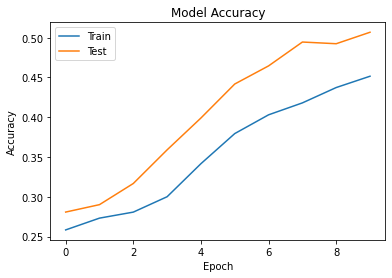

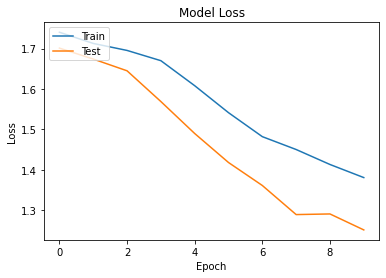

In [80]:
# plot accuracy of all models on one plot 
import matplotlib.pyplot as plt
 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show() 


# plot loss of all models on one plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Confusion Matrix
[[129  58 336 193 128 114]
 [130  62 348 219 124 141]
 [212  82 622 388 227 243]
 [167  66 423 237 158 182]
 [174  53 435 266 173 146]
 [119  38 292 173 101 108]]


Text(69.0, 0.5, 'Truth')

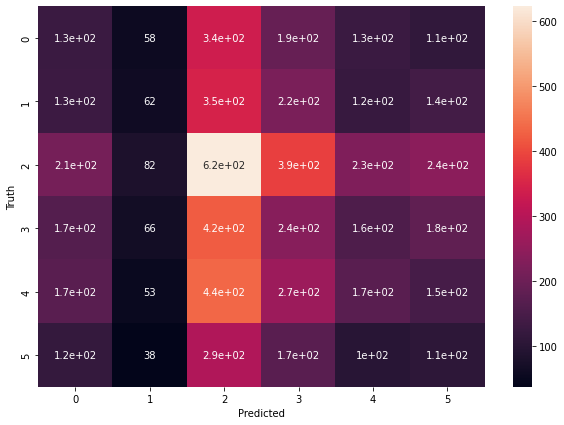

In [97]:
# Confusion Matrix
#model_adam

from sklearn.metrics import confusion_matrix
import seaborn as sns
    
y_pred = model_adam.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
cm = confusion_matrix(validation_generator.classes, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
 

Confusion Matrix
[[103  72 297 198 199  89]
 [116  84 303 230 184 107]
 [183 150 548 319 396 178]
 [158  81 377 254 256 107]
 [133  92 390 239 259 134]
 [ 90  58 230 182 181  90]]


Text(69.0, 0.5, 'Truth')

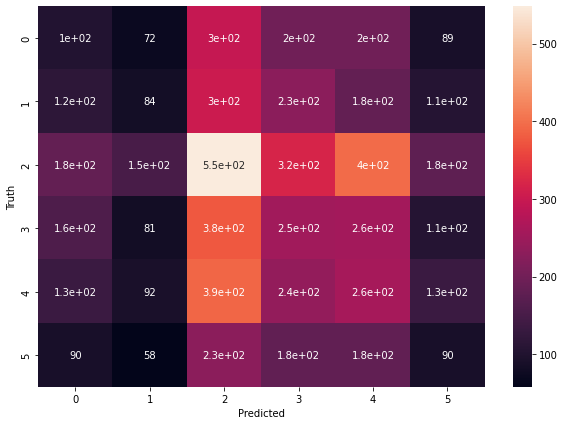

In [98]:
# Confusion Matrix
# model
from sklearn.metrics import confusion_matrix
import seaborn as sns
    
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
cm = confusion_matrix(validation_generator.classes, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
 


Confusion Matrix
[[   1    0  832    0  125    0]
 [   0    0  906    0  118    0]
 [   0    0 1586    0  188    0]
 [   0    0 1092    0  141    0]
 [   0    0 1103    0  144    0]
 [   0    0  731    0  100    0]]


Text(69.0, 0.5, 'Truth')

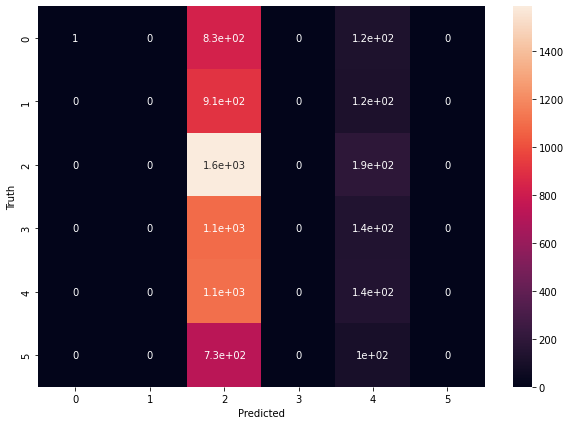

In [99]:
# Confusion Matrix
# model_swish

from sklearn.metrics import confusion_matrix
import seaborn as sns
    
y_pred = model_swish.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
cm = confusion_matrix(validation_generator.classes, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
 


Confusion Matrix
[[121  34 295 246 141 121]
 [143  46 272 259 160 144]
 [212  75 516 487 251 233]
 [118  59 347 317 211 181]
 [136  62 390 309 189 161]
 [ 97  37 239 228 117 113]]


Text(69.0, 0.5, 'Truth')

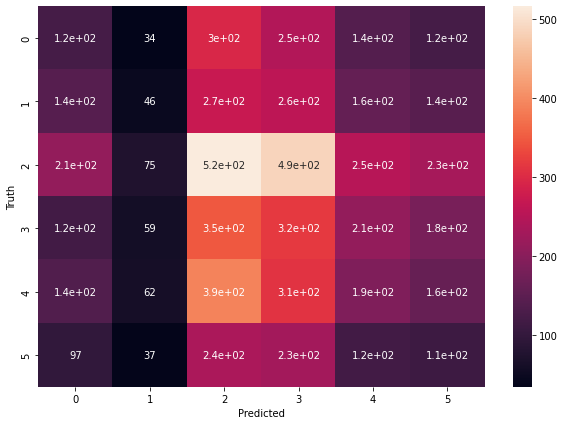

In [100]:
# Confusion Matrix
# model_adam_swish

from sklearn.metrics import confusion_matrix
import seaborn as sns
    
y_pred = model_adam_swish.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
cm = confusion_matrix(validation_generator.classes, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
 

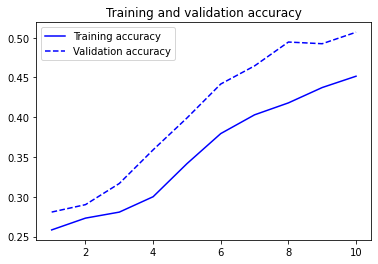

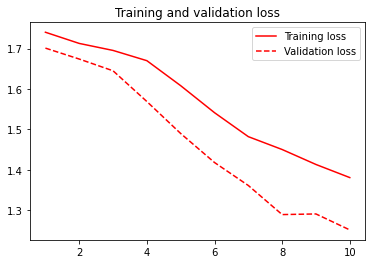

In [96]:
# plot accuracy and loss

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# accuracy

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'b--', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# loss

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'r--', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()